In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, f1_score, roc_curve

RANDOM_SEED = 42
TEST_SIZE   = 0.2

data_path   = Path("../data/processed/employee_salary_final.csv")
model_dir   = Path("../models")
model_dir.mkdir(exist_ok=True)


In [2]:
df = pd.read_csv(data_path)
df.head()


,age,workclass,educational-num,occupation,hours-per-week,capital-gain,capital-loss,income
0,25,Private,7,Machine-op-inspct,40,0,0,<=50K
1,38,Private,9,Farming-fishing,50,0,0,<=50K
2,28,Local-gov,12,Protective-serv,40,0,0,>50K
3,44,Private,10,Machine-op-inspct,40,7688,0,>50K
4,18,?,10,?,30,0,0,<=50K


In [3]:
X = df.drop(columns=["income"])
y = (df["income"] == ">50K").astype(int)

cat_cols = ["workclass", "occupation"]
num_cols = [c for c in X.columns if c not in cat_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=TEST_SIZE, random_state=RANDOM_SEED
)


In [4]:
preproc = ColumnTransformer(
    [
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ]
)


In [5]:
# Logistic Regression baseline
log_clf = Pipeline([
    ("prep", preproc),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_SEED))
])

# Histogram Gradient‑Boosting
boost_clf = Pipeline([
    ("prep", preproc),
    ("model", HistGradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=None,
        max_iter=400,
        l2_regularization=1.0,
        random_state=RANDOM_SEED,
    ))
])


In [6]:
def fit_eval(pipe, name):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    roc  = roc_auc_score(y_test, y_prob)
    f1   = f1_score(y_test, y_pred)
    print(f"{name:20s}  ROC‑AUC: {roc:.3f}  •  F1: {f1:.3f}")
    return pipe, roc, f1, y_prob

log_model , roc_log , f1_log , prob_log   = fit_eval(log_clf , "Logistic Regression")
boost_model, roc_boost, f1_boost, prob_boost = fit_eval(boost_clf, "HistGradientBoost")

# Quick comparison table
import pandas as pd
pd.DataFrame({
    "Model": ["Logistic", "HistGB"],
    "ROC‑AUC": [roc_log, roc_boost],
    "F1": [f1_log, f1_boost]
})


Logistic Regression   ROC‑AUC: 0.842  •  F1: 0.605
HistGradientBoost     ROC‑AUC: 0.885  •  F1: 0.627


,Model,ROC‑AUC,F1
0,Logistic,0.842246,0.604805
1,HistGB,0.885262,0.627451


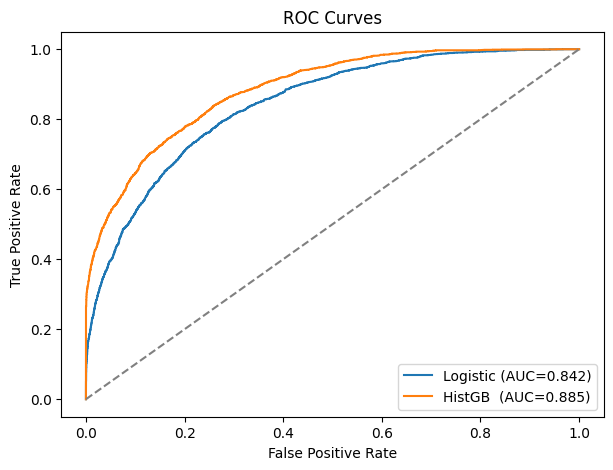

In [7]:
fpr_log,   tpr_log,   _ = roc_curve(y_test, prob_log)
fpr_boost, tpr_boost, _ = roc_curve(y_test, prob_boost)

plt.figure(figsize=(7,5))
plt.plot(fpr_log,   tpr_log,   label=f"Logistic (AUC={roc_log:.3f})")
plt.plot(fpr_boost, tpr_boost, label=f"HistGB  (AUC={roc_boost:.3f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(); plt.show()


In [8]:
import joblib
best_model_path = model_dir / "model_boost_notebook.pkl"
joblib.dump(boost_model, best_model_path)
print(f"✅ Saved notebook-trained HistGB to {best_model_path}")


✅ Saved notebook-trained HistGB to ..\models\model_boost_notebook.pkl
